### Optimisation of a Neocortical Layer 5 Pyramidal Cell 20 GEN 100 OFFSPRINGS <-- WORKED!

This notebook shows you how to optimise the maximal conductance of Neocortical Layer 5 Pyramidal Cell as used in Markram et al. 2015.

Author of this script: Werner Van Geit @ Blue Brain Project

Choice of parameters, protocols and other settings was done by Etay Hay @ HUJI

What's described here is a more advanced use of BluePyOpt. We suggest to first go through the introductary example here: https://github.com/BlueBrain/BluePyOpt/blob/master/examples/simplecell/simplecell.ipynb

If you use the methods in this notebook, we ask you to cite the following publications when publishing your research:

Van Geit, W., M. Gevaert, G. Chindemi, C. Rössert, J.-D. Courcol, E. Muller, F. Schürmann, I. Segev, and H. Markram (2016, March). BluePyOpt: Leveraging open source software and cloud infrastructure to optimise model parameters in neuroscience. ArXiv e-prints. http://arxiv.org/abs/1603.00500

Markram, H., E. Muller, S. Ramaswamy, M. W. Reimann, M. Abdellah, C. A. Sanchez, A. Ailamaki, L. Alonso-Nanclares, N. Antille, S. Arsever, et al. (2015). Reconstruction and simulation of neocortical microcircuitry. Cell 163(2), 456–492. http://www.cell.com/abstract/S0092-8674%2815%2901191-5

Some of the modules loaded in this script are located in the L5PC example folder: https://github.com/BlueBrain/BluePyOpt/tree/master/examples/l5pc

We first load the bluepyopt python module, the ephys submodule and some helper functionality REAL ONE


## install software and data

In [1]:
 # To avoid problems, install the pacakges you will need.
! pip install mpmath==0.19
! pip install json2html
! pip install -q --upgrade "hbp-service-client==1.0.0"

### Restart your kernel now

In [1]:
!pip install PyYAML==3.10

In [2]:
!pip -q install neurom --upgrade
!pip uninstall -y nsg-bluepyopt-job
!pip -q install https://github.com/jdcourcol/InSilicoNeuroscienceCourse/raw/master/nsg-portal-course/utils/nsg-bluepyopt-job-0.0.1.dev0.tar.gz

Uninstalling nsg-bluepyopt-job-0.0.1.dev0:
  Successfully uninstalled nsg-bluepyopt-job-0.0.1.dev0


### Call and unzip the zip folder

In [3]:
# First be sure that you have no directory or file repeted -- use <!ls> to check your files
# In case you have any, use <!rm -r 'filename.extension' or /directory/> to remove it

# SEBASTIEN: you have to remove everything from tmp/ and everything from the first level directory
# a part of tmp and work. Basically you need to have this output.

!rm -r __MACOSX/
!rm -r model/
!rm -r model.zip
!rm -r x86_64/
!rm -r tmp/model/
!rm -r tmp/output.tar.gz
!ls tmp/
!ls

rm: cannot remove ‘__MACOSX/’: No such file or directory
__init__.py	  l5pc_evaluator.py  mechanisms  opt_neuron.py
l5pc_analysis.py  l5pc_model.py      morphology
tmp


In [4]:
# Now call the 'model.zip' from storage
extension = '.zip'
file_name = 'model' # folder name
full_name = file_name + extension
clients = get_hbp_service_client()
collab_path = get_collab_storage_path()
data_dir = collab_path + '/%s' % full_name
clients.storage.download_file(data_dir, full_name)

In [5]:
!ls

model.zip  tmp


In [6]:
# Let's decompress the folder
!unzip -q {full_name}

In [7]:
# Let's see what is inside the folder
!ls 
!ls model/
!rm -r __MACOSX
!ls

__MACOSX  model  model.zip  tmp
checkpoints  __init__.py       l5pc_evaluator.py  morphology
config	     init.py	       l5pc_model.py	  opt_neuron.py
config.orig  l5pc_analysis.py  mechanisms
model  model.zip  tmp


In [8]:
# compile .MOD files for the ion channels
!nrnivmodl model/mechanisms/

Creating x86_64 directory for .o files.

/home/jovyan
model/mechanisms//CaDynamics_E2.mod model/mechanisms//Ca_HVA.mod model/mechanisms//Ca_LVAst.mod model/mechanisms//Ih.mod model/mechanisms//Im.mod model/mechanisms//K_Pst.mod model/mechanisms//K_Tst.mod model/mechanisms//NaTa_t.mod model/mechanisms//NaTs2_t.mod model/mechanisms//Nap_Et2.mod model/mechanisms//ProbAMPANMDA_EMS.mod model/mechanisms//ProbGABAAB_EMS.mod model/mechanisms//SK_E2.mod model/mechanisms//SKv3_1.mod
CaDynamics_E2.mod Ca_HVA.mod Ca_LVAst.mod Ih.mod Im.mod K_Pst.mod K_Tst.mod NaTa_t.mod NaTs2_t.mod Nap_Et2.mod ProbAMPANMDA_EMS.mod ProbGABAAB_EMS.mod SK_E2.mod SKv3_1.mod
"/usr/local/nrn/x86_64/bin/nocmodl" CaDynamics_E2
Translating CaDynamics_E2.mod into CaDynamics_E2.c
Thread Safe
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o CaDynamics_E2.lo CaDynamics_E2.c
libtool: compile:  gcc -DHAVE_CONFIG

libtool: link: (cd ".libs" && rm -f "libnrnmech.so.0" && ln -s "libnrnmech.so.0.0.0" "libnrnmech.so.0")
libtool: link: (cd ".libs" && rm -f "libnrnmech.so" && ln -s "libnrnmech.so.0.0.0" "libnrnmech.so")
libtool: link: ( cd ".libs" && rm -f "libnrnmech.la" && ln -s "../libnrnmech.la" "libnrnmech.la" )
Successfully created x86_64/special


In [9]:
# Check the folder x86_64 has been created
! ls 

model  model.zip  tmp  x86_64


In [10]:
%load_ext autoreload
%autoreload
import getpass
import os.path
from __future__ import print_function
import pprint
import bluepyopt
import bluepyopt.ephys as ephys
pp = pprint.PrettyPrinter(indent=2)

Enable the code below to enable debug level logging

In [11]:
working_directory = 'model'

## Model description

### Morphology

We're using a complex reconstructed morphology of an L5PC cell. Let's visualise this with the BlueBrain NeuroM software:

In [12]:
# TODO: your group's morphology must be added to the directory morphology
morphology_filename = 'model/morphology/vd110611_idA.asc'

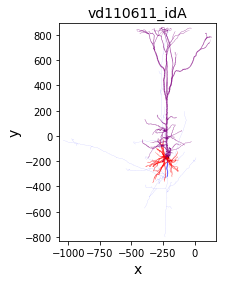

In [14]:
# SEBASTIEN: you have to run this cell two times to be able to see the morphology.
# I don't know exactly why is a collab issue.

import matplotlib.pyplot as plt
import neurom.viewer

neurom.viewer.draw(neurom.load_neuron(os.path.join(working_directory, 'morphology', 'vd110611_idA.asc')))

plt.show()


To load the morphology we create a NrnFileMorphology object. We set 'do_replace_axon' to True to replace the axon with a Axon Initial Segment.

In [15]:
morphology = ephys.morphologies.NrnFileMorphology(morphology_filename, do_replace_axon=True)

print(str(morphology))

model/morphology/vd110611_idA.asc


### Parameters

Since we have many parameters in this model, they are stored in a json file: https://github.com/BlueBrain/BluePyOpt/blob/master/examples/l5pc/config/parameters.json

In [16]:
# Example of json entry: Frozen Parameter for the equilibrum membrane potential
{
    "param_name": "e_pas",
    "sectionlist": "all",
    "type": "section",
    "dist_type": "uniform",
    "value": -75
},
# Example of json entry: Bounded Parameter
{
    "param_name": "gNaTs2_tbar_NaTs2_t",
    "mech": "NaTs2_t",
    "bounds": [
        0,
        1
    ],
    "dist_type": "uniform",
    "mech_param": "gNaTs2_tbar",
    "type": "range",
    "sectionlist": "somatic"
},

({'bounds': [0, 1],
  'dist_type': 'uniform',
  'mech': 'NaTs2_t',
  'mech_param': 'gNaTs2_tbar',
  'param_name': 'gNaTs2_tbar_NaTs2_t',
  'sectionlist': 'somatic',
  'type': 'range'},)

In [17]:
import json

param_configs = json.load(open(os.path.join(working_directory, 'config.orig/parameters.json')))
#param_configs = json.load(open(os.path.join(WORKING_DIR,'config.orig/parameters.json')))
print(param_configs)

[{u'param_name': u'g_pas', u'value': 3e-05, u'type': u'section', u'dist_type': u'uniform', u'sectionlist': u'all'}, {u'param_name': u'e_pas', u'value': -75, u'type': u'section', u'dist_type': u'uniform', u'sectionlist': u'all'}, {u'param_name': u'cm', u'value': 1, u'type': u'section', u'dist_type': u'uniform', u'sectionlist': u'all'}, {u'param_name': u'Ra', u'value': 100, u'type': u'section', u'dist_type': u'uniform', u'sectionlist': u'all'}, {u'param_name': u'v_init', u'type': u'global', u'value': -65}, {u'param_name': u'celsius', u'type': u'global', u'value': 34}, {u'param_name': u'ena', u'value': 50, u'type': u'section', u'dist_type': u'uniform', u'sectionlist': u'somatic'}, {u'param_name': u'ek', u'value': -85, u'type': u'section', u'dist_type': u'uniform', u'sectionlist': u'somatic'}, {u'param_name': u'gNaTs2_tbar_NaTs2_t', u'mech': u'NaTs2_t', u'bounds': [0, 1], u'dist_type': u'uniform', u'mech_param': u'gNaTs2_tbar', u'type': u'range', u'sectionlist': u'somatic'}, {u'param_name'

In [18]:
# Let's write them as a table

print('{0:<25}: {1:<10}: {2:<15}: {3:<10}: {4:<10}'.format('Parameter Name',
                                                           'Par Type',
                                                           'Value',
                                                           'SecList',
                                                           'Distribution Type'))
print('-'*100)
for param_config in param_configs:
    
    string = '{0:<25}: {1:<10}: '.format(param_config['param_name'],
                                         param_config['type'])

    if 'value' in param_config:
        string += '{0:<15}: '.format(param_config['value'])
    elif 'range' in param_config['type']:
        string += '{0:<15}: '.format(param_config['bounds'])

    if 'sectionlist' in param_config:
        string += '{0:<10}: '.format(param_config['sectionlist'])
    else:
        string += '{0:<10}: '.format('NA')

    if 'dist_type' in param_config:
        
        string += '{0:<10}'.format(param_config['dist_type'])
    else:
        string += '{0:<10}'.format('NA')

    print(string)

Parameter Name           : Par Type  : Value          : SecList   : Distribution Type
----------------------------------------------------------------------------------------------------
g_pas                    : section   : 3e-05          : all       : uniform   
e_pas                    : section   : -75            : all       : uniform   
cm                       : section   : 1              : all       : uniform   
Ra                       : section   : 100            : all       : uniform   
v_init                   : global    : -65            : NA        : NA        
celsius                  : global    : 34             : NA        : NA        
ena                      : section   : 50             : somatic   : uniform   
ek                       : section   : -85            : somatic   : uniform   
gNaTs2_tbar_NaTs2_t      : range     : [0, 1]         : somatic   : uniform   
gSKv3_1bar_SKv3_1        : range     : [0, 1]         : somatic   : uniform   
gSK_E2bar_SK_E2        

As you can see there are two types of parameters, parameters __with a fixed value__ and parameters __with bounds__. The latter will be optimised by the algorithm.

Now we define a function that will load all the parameters in BluePyOpt Parameter objects

In [19]:
config_dir = working_directory + '/config.orig'

In [20]:
import os
import json
import bluepyopt.ephys as ephys

def define_parameters():
    """Define parameters"""

    param_configs = json.load(open(os.path.join(config_dir, 'parameters.json')))
    parameters = []

    for param_config in param_configs:
        if 'value' in param_config:
            frozen = True
            value = param_config['value']
            bounds = None
        elif 'bounds' in param_config:
            frozen = False
            bounds = param_config['bounds']
            value = None
        else:
            raise Exception(
                'Parameter config has to have bounds or value: %s'
                % param_config)

        if param_config['type'] == 'global':
            parameters.append(
                ephys.parameters.NrnGlobalParameter(
                    name=param_config['param_name'],
                    param_name=param_config['param_name'],
                    frozen=frozen,
                    bounds=bounds,
                    value=value))
        elif param_config['type'] in ['section', 'range']:
            if param_config['dist_type'] == 'uniform':
                scaler = ephys.parameterscalers.NrnSegmentLinearScaler()
            elif param_config['dist_type'] == 'exp':
                scaler = ephys.parameterscalers.NrnSegmentSomaDistanceScaler(
                    distribution=param_config['dist'])
            seclist_loc = ephys.locations.NrnSeclistLocation(
                param_config['sectionlist'],
                seclist_name=param_config['sectionlist'])

            name = '%s.%s' % (param_config['param_name'],
                              param_config['sectionlist'])

            if param_config['type'] == 'section':
                parameters.append(
                    ephys.parameters.NrnSectionParameter(
                        name=name,
                        param_name=param_config['param_name'],
                        value_scaler=scaler,
                        value=value,
                        frozen=frozen,
                        bounds=bounds,
                        locations=[seclist_loc]))
            elif param_config['type'] == 'range':
                parameters.append(
                    ephys.parameters.NrnRangeParameter(
                        name=name,
                        param_name=param_config['param_name'],
                        value_scaler=scaler,
                        value=value,
                        frozen=frozen,
                        bounds=bounds,
                        locations=[seclist_loc]))
        else:
            raise Exception(
                'Param config type has to be global, section or range: %s' %
                param_config)

    return parameters

In [21]:
parameters = define_parameters()

for p in parameters:
    print('{0:<50}: {1:<10}'.format(p.name, p.value if p.frozen else p.bounds))

g_pas.all                                         : 3e-05     
e_pas.all                                         : -75       
cm.all                                            : 1         
Ra.all                                            : 100       
v_init                                            : -65       
celsius                                           : 34        
ena.somatic                                       : 50        
ek.somatic                                        : -85       
gNaTs2_tbar_NaTs2_t.somatic                       : [0, 1]    
gSKv3_1bar_SKv3_1.somatic                         : [0, 1]    
gSK_E2bar_SK_E2.somatic                           : [0, 0.1]  
gCa_HVAbar_Ca_HVA.somatic                         : [0, 0.001]
gCa_LVAstbar_Ca_LVAst.somatic                     : [0, 0.01] 
gamma_CaDynamics_E2.somatic                       : [0.0005, 0.05]
decay_CaDynamics_E2.somatic                       : [20, 1000]
gIhbar_Ih.somatic                                 :

## Mechanism

We also need to add all the necessary mechanisms, like ion channels to the model. The configuration of the mechanisms is also stored in a json file, and can be loaded in a similar way.

In [22]:
def define_mechanisms():
    """Define mechanisms"""

    mech_definitions = json.load(
        open(
            os.path.join(
                config_dir,
                'mechanisms.json')))

    mechanisms = []
    for sectionlist, channels in mech_definitions.items():
        seclist_loc = ephys.locations.NrnSeclistLocation(
            sectionlist,
            seclist_name=sectionlist)
        for channel in channels:
            mechanisms.append(ephys.mechanisms.NrnMODMechanism(
                name='%s.%s' % (channel, sectionlist),
                mod_path=None,
                suffix=channel,
                locations=[seclist_loc],
                preloaded=True))

    return mechanisms

In [23]:
mechanisms = define_mechanisms()

print('\n'.join(map(str, mechanisms)))

pas.all: pas at ['all']
NaTs2_t.somatic: NaTs2_t at ['somatic']
SKv3_1.somatic: SKv3_1 at ['somatic']
SK_E2.somatic: SK_E2 at ['somatic']
CaDynamics_E2.somatic: CaDynamics_E2 at ['somatic']
Ca_HVA.somatic: Ca_HVA at ['somatic']
Ca_LVAst.somatic: Ca_LVAst at ['somatic']
Ih.somatic: Ih at ['somatic']


# Cell model

With the morphology, mechanisms and parameters we can build the cell model

In [24]:
l5pc_cell = ephys.models.CellModel('l5pc', morph=morphology, mechs=mechanisms, params=parameters)
print(l5pc_cell)

l5pc:
  morphology:
    model/morphology/vd110611_idA.asc
  mechanisms:
    pas.all: pas at ['all']
    NaTs2_t.somatic: NaTs2_t at ['somatic']
    SKv3_1.somatic: SKv3_1 at ['somatic']
    SK_E2.somatic: SK_E2 at ['somatic']
    CaDynamics_E2.somatic: CaDynamics_E2 at ['somatic']
    Ca_HVA.somatic: Ca_HVA at ['somatic']
    Ca_LVAst.somatic: Ca_LVAst at ['somatic']
    Ih.somatic: Ih at ['somatic']
  params:
    g_pas.all: ['all'] g_pas = 3e-05
    e_pas.all: ['all'] e_pas = -75
    cm.all: ['all'] cm = 1
    Ra.all: ['all'] Ra = 100
    v_init: v_init = -65
    celsius: celsius = 34
    ena.somatic: ['somatic'] ena = 50
    ek.somatic: ['somatic'] ek = -85
    gNaTs2_tbar_NaTs2_t.somatic: ['somatic'] gNaTs2_tbar_NaTs2_t = [0, 1]
    gSKv3_1bar_SKv3_1.somatic: ['somatic'] gSKv3_1bar_SKv3_1 = [0, 1]
    gSK_E2bar_SK_E2.somatic: ['somatic'] gSK_E2bar_SK_E2 = [0, 0.1]
    gCa_HVAbar_Ca_HVA.somatic: ['somatic'] gCa_HVAbar_Ca_HVA = [0, 0.001]
    gCa_LVAstbar_Ca_LVAst.somatic: ['somatic']

For use in the cell evaluator later, we need to make a list of the name of the parameters we are going to optimise. These are the parameters that are not frozen.

In [25]:
param_names = [param.name for param in l5pc_cell.params.values() if not param.frozen]   

## Protocols

Now that we have a cell model, we can apply protocols to it. The protocols are also stored in a json file.

In [26]:
proto_configs = json.load(open(os.path.join(config_dir, 'protocols.json')))

for key, value in proto_configs.items():
    print(key)
    for stimulus in value['stimuli']:
        print('\t', stimulus)

Step1
	 {u'delay': 700, u'amp': 0.458, u'duration': 2000, u'totduration': 3000}
	 {u'delay': 0, u'amp': -0.126, u'duration': 3000, u'totduration': 3000}
Step3
	 {u'delay': 700, u'amp': 0.95, u'duration': 2000, u'totduration': 3000}
	 {u'delay': 0, u'amp': -0.126, u'duration': 3000, u'totduration': 3000}
Step2
	 {u'delay': 700, u'amp': 0.562, u'duration': 2000, u'totduration': 3000}
	 {u'delay': 0, u'amp': -0.126, u'duration': 3000, u'totduration': 3000}
bAP
	 {u'delay': 295, u'amp': 1.9, u'duration': 5, u'totduration': 600}


And they can be automatically loaded

In [27]:
def define_protocols():
    """Define protocols"""

    protocol_definitions = json.load(
        open(
            os.path.join(
                config_dir,
                'protocols.json')))

    protocols = {}

    soma_loc = ephys.locations.NrnSeclistCompLocation(
        name='soma',
        seclist_name='somatic',
        sec_index=0,
        comp_x=0.5)

    for protocol_name, protocol_definition in protocol_definitions.items():
        # By default include somatic recording
        somav_recording = ephys.recordings.CompRecording(
            name='%s.soma.v' %
            protocol_name,
            location=soma_loc,
            variable='v')

        recordings = [somav_recording]

        if 'extra_recordings' in protocol_definition:
            for recording_definition in protocol_definition['extra_recordings']:
                if recording_definition['type'] == 'somadistance':
                    location = ephys.locations.NrnSomaDistanceCompLocation(
                        name=recording_definition['name'],
                        soma_distance=recording_definition['somadistance'],
                        seclist_name=recording_definition['seclist_name'])
                    var = recording_definition['var']
                    recording = ephys.recordings.CompRecording(
                        name='%s.%s.%s' % (protocol_name, location.name, var),
                        location=location,
                        variable=recording_definition['var'])

                    recordings.append(recording)
                else:
                    raise Exception(
                        'Recording type %s not supported' %
                        recording_definition['type'])

        stimuli = []
        for stimulus_definition in protocol_definition['stimuli']:
            stimuli.append(ephys.stimuli.NrnSquarePulse(
                step_amplitude=stimulus_definition['amp'],
                step_delay=stimulus_definition['delay'],
                step_duration=stimulus_definition['duration'],
                location=soma_loc,
                total_duration=stimulus_definition['totduration']))

        protocols[protocol_name] = ephys.protocols.SweepProtocol(
            protocol_name,
            stimuli,
            recordings)

    return protocols

In [28]:
fitness_protocols = define_protocols()
print('\n'.join('%s' % protocol for protocol in fitness_protocols.values()))

bAP:
  stimuli:
    Square pulse amp 1.900000 delay 295.000000 duration 5.000000 totdur 600.000000 at somatic[0](0.5)
  recordings:
    bAP.soma.v: v at somatic[0](0.5)
    bAP.dend1.v: v at 660.000000 micron from soma in apical
    bAP.dend2.v: v at 800.000000 micron from soma in apical

Step3:
  stimuli:
    Square pulse amp 0.950000 delay 700.000000 duration 2000.000000 totdur 3000.000000 at somatic[0](0.5)
    Square pulse amp -0.126000 delay 0.000000 duration 3000.000000 totdur 3000.000000 at somatic[0](0.5)
  recordings:
    Step3.soma.v: v at somatic[0](0.5)

Step2:
  stimuli:
    Square pulse amp 0.562000 delay 700.000000 duration 2000.000000 totdur 3000.000000 at somatic[0](0.5)
    Square pulse amp -0.126000 delay 0.000000 duration 3000.000000 totdur 3000.000000 at somatic[0](0.5)
  recordings:
    Step2.soma.v: v at somatic[0](0.5)

Step1:
  stimuli:
    Square pulse amp 0.458000 delay 700.000000 duration 2000.000000 totdur 3000.000000 at somatic[0](0.5)
    Square pulse amp

## eFeatures

For every protocol we need to define which eFeatures will be used as objectives of the optimisation algorithm.

In [29]:
feature_configs = json.load(open(os.path.join(config_dir,'features.json')))
pp.pprint(feature_configs)

{ u'Step1': { u'soma': { u'AHP_depth_abs': [-60.3636, 2.3018],
                         u'AHP_depth_abs_slow': [-61.1513, 2.3385],
                         u'AHP_slow_time': [0.1599, 0.0483],
                         u'AP_height': [25.0141, 3.1463],
                         u'AP_width': [3.5312, 0.8592],
                         u'ISI_CV': [0.109, 0.1217],
                         u'adaptation_index2': [0.0047, 0.0514],
                         u'doublet_ISI': [62.75, 9.6667],
                         u'mean_frequency': [6, 1.2222],
                         u'time_to_first_spike': [27.25, 5.7222]}},
  u'Step2': { u'soma': { u'AHP_depth_abs': [-59.9055, 1.8329],
                         u'AHP_depth_abs_slow': [-60.2471, 1.8972],
                         u'AHP_slow_time': [0.1676, 0.0339],
                         u'AP_height': [27.1003, 3.1463],
                         u'AP_width': [2.7917, 0.7499],
                         u'ISI_CV': [0.0674, 0.075],
                         u'adaptat

In [30]:
def define_fitness_calculator(protocols):
    """Define fitness calculator"""

    feature_definitions = json.load(
        open(
            os.path.join(
                config_dir,
                'features.json')))

    # TODO: add bAP stimulus
    objectives = []

    for protocol_name, locations in feature_definitions.items():
        for location, features in locations.items():
            for efel_feature_name, meanstd in features.items():
                feature_name = '%s.%s.%s' % (
                    protocol_name, location, efel_feature_name)
                recording_names = {'': '%s.%s.v' % (protocol_name, location)}
                stimulus = protocols[protocol_name].stimuli[0]

                stim_start = stimulus.step_delay

                if location == 'soma':
                    threshold = -20
                elif 'dend' in location:
                    threshold = -55

                if protocol_name == 'bAP':
                    stim_end = stimulus.total_duration
                else:
                    stim_end = stimulus.step_delay + stimulus.step_duration

                feature = ephys.efeatures.eFELFeature(
                    feature_name,
                    efel_feature_name=efel_feature_name,
                    recording_names=recording_names,
                    stim_start=stim_start,
                    stim_end=stim_end,
                    exp_mean=meanstd[0],
                    exp_std=meanstd[1],
                    threshold=threshold)
                objective = ephys.objectives.SingletonObjective(
                    feature_name,
                    feature)
                objectives.append(objective)

    fitcalc = ephys.objectivescalculators.ObjectivesCalculator(objectives)

    return fitcalc

In [31]:
fitness_calculator = define_fitness_calculator(fitness_protocols)
print(fitness_calculator)

objectives:
  ( AP_height for {'': u'Step1.soma.v'} with stim start 700 and end 2700, exp mean 25.0141 and std 3.1463 and AP threshold override -20 )
  ( AHP_slow_time for {'': u'Step1.soma.v'} with stim start 700 and end 2700, exp mean 0.1599 and std 0.0483 and AP threshold override -20 )
  ( ISI_CV for {'': u'Step1.soma.v'} with stim start 700 and end 2700, exp mean 0.109 and std 0.1217 and AP threshold override -20 )
  ( doublet_ISI for {'': u'Step1.soma.v'} with stim start 700 and end 2700, exp mean 62.75 and std 9.6667 and AP threshold override -20 )
  ( AHP_depth_abs_slow for {'': u'Step1.soma.v'} with stim start 700 and end 2700, exp mean -61.1513 and std 2.3385 and AP threshold override -20 )
  ( AP_width for {'': u'Step1.soma.v'} with stim start 700 and end 2700, exp mean 3.5312 and std 0.8592 and AP threshold override -20 )
  ( time_to_first_spike for {'': u'Step1.soma.v'} with stim start 700 and end 2700, exp mean 27.25 and std 5.7222 and AP threshold override -20 )
  ( AHP_

## Simulator

We need to define which simulator we will use. In this case it will be Neuron, i.e. the NrnSimulator class

In [32]:
sim = ephys.simulators.NrnSimulator()

## Evaluator

With all the components defined above we can build a cell evaluator

In [33]:
evaluator = ephys.evaluators.CellEvaluator(                                          
        cell_model=l5pc_cell,                                                       
        param_names=param_names,                                                    
        fitness_protocols=fitness_protocols,                                        
        fitness_calculator=fitness_calculator,                                      
        sim=sim)  

This evaluator can be used to run the protocols. The original parameter values for the Markram et al. 2015 L5PC model are:

In [34]:
release_params = {
    'gamma_CaDynamics_E2.somatic': 0.000609,
    'gSKv3_1bar_SKv3_1.somatic': 0.303472,
    'gSK_E2bar_SK_E2.somatic': 0.008407,
    'gCa_HVAbar_Ca_HVA.somatic': 0.000994,
    'gNaTs2_tbar_NaTs2_t.somatic': 0.983955,
    'decay_CaDynamics_E2.somatic': 210.485284,
    'gCa_LVAstbar_Ca_LVAst.somatic': 0.000333
}

Running the responses is as easy as passing the protocols and parameters to the evaluator. (The line below will take some time to execute)

In [35]:
release_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=release_params)

We can now plot all the responses

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


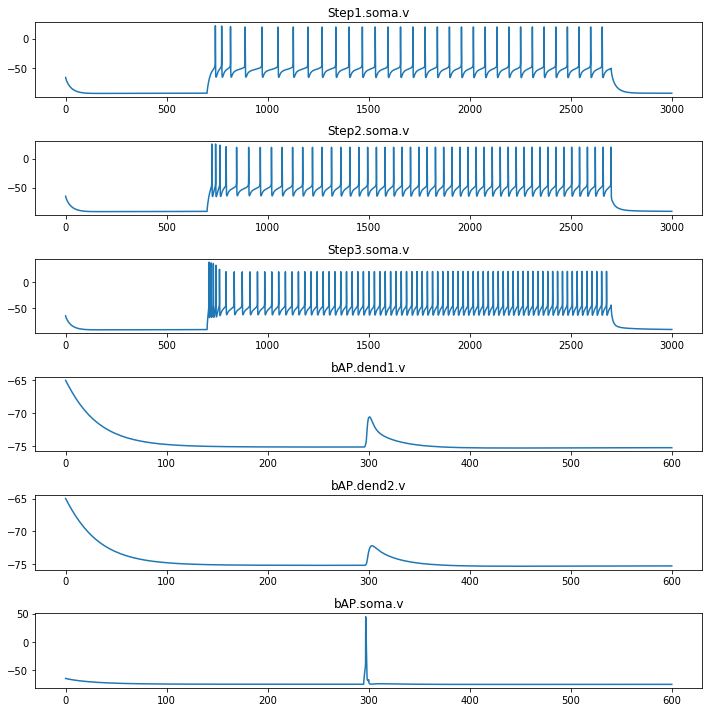

In [36]:
import matplotlib.pyplot as plt

def plot_responses(responses):
    fig, axes = plt.subplots(len(responses), figsize=(10,10))
    for index, (resp_name, response) in enumerate(sorted(responses.items())):
        axes[index].plot(response['time'], response['voltage'], label=resp_name)
        axes[index].set_title(resp_name)
    fig.tight_layout()
    fig.show()
plot_responses(release_responses)

## save configuration

In [37]:
modified_config_dir = os.path.join(working_directory, 'config')

In [38]:
for variable, filename in zip([param_configs, proto_configs, feature_configs],['parameters.json', 'protocols.json', 'features.json']):
    with open(os.path.join(modified_config_dir, filename), 'w') as f:
        json.dump(variable, f)

# Check if is true that we wrote the json files into the config folder 
! ls model/config


features.json  mechanisms.json	parameters.json  protocols.json


In [39]:
# copy the unzip model directory into ./tmp/ <---- THIS LINE !!!
# that is a requisit for NSG portal
!cp -R model ./tmp/
# check that we really copy it properly
!ls tmp/

__init__.py	  l5pc_evaluator.py  mechanisms  morphology
l5pc_analysis.py  l5pc_model.py      model	 opt_neuron.py


In [40]:
# Compress tmp directory into a new model.zip
# that is also mandatory for the NSG portal
import shutil
shutil.make_archive('model', 'zip', './tmp/')

'/home/jovyan/model.zip'

In [41]:
# Check that model.zip has been created
! ls 

model  model.zip  tmp  x86_64


In [42]:
# Check the model.zip file that you have created right now.
# Is important that the structure of the file is the good one.
# Basically we have to be sure that inside the "config" folder we have writen the json files
# Check that inside the zip file there is no other strange files (as __MACOXS)
from IPython.display import FileLink  

In [43]:
FileLink('./model.zip')

/home/jovyan/model.zip

## launch optimization on the nsg-portal compute center

In [44]:
user = 'insilicoteam.ois' #'put your nsg_portal account id here'insilicoteam.ois :: 6n3-7dv-k4p-L5E 

In [45]:
# run the cell - you will see an empty space to write your password
# after writing the password press ENTER !!! (don't run the cell)
password = getpass.getpass('provide your password:')

provide your password:········


In [46]:
# If you want to check that you introduced the correct password
print(password)

6n3-7dv-k4p-L5E


In [47]:
import logging                                                                      
logging.basicConfig()                                                               
logger = logging.getLogger()                                                        
logger.setLevel(logging.DEBUG)   

In [48]:
!pip -q install https://github.com/jdcourcol/InSilicoNeuroscienceCourse/raw/master/nsg-portal-course/utils/nsg-bluepyopt-job-0.0.1.dev0.tar.gz
import nsg_bluepyopt_job.job as job

In [49]:
job_url = job.launch_opt(user, password, 'model.zip')

INFO:nsg_bluepyopt_job.job:launch_opt(insilicoteam.ois, xxx, model.zip, 10, 2 , 0)
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): nsgr.sdsc.edu
DEBUG:urllib3.connectionpool:https://nsgr.sdsc.edu:8443 "POST /cipresrest/v1/job/insilicoteam.ois HTTP/1.1" 200 None


In [50]:
# Launch the compress file into the NSG portal for the optimization
# Go to read a good research paper, take a coffee or prepare the presentation for next week 
# that will take TIME !!!
output_url = job.wait_completion(job_url, user, password, 850)

INFO:nsg_bluepyopt_job.job:Check_job_status(https://nsgr.sdsc.edu:8443/cipresrest/v1/job/insilicoteam.ois/NGBW-JOB-BLUEPYOPT_TG-5BC07C23701B4B96A19ED1BB7F891ED9, insilicoteam.ois, xxxx)
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): nsgr.sdsc.edu
DEBUG:urllib3.connectionpool:https://nsgr.sdsc.edu:8443 "GET /cipresrest/v1/job/insilicoteam.ois/NGBW-JOB-BLUEPYOPT_TG-5BC07C23701B4B96A19ED1BB7F891ED9 HTTP/1.1" 200 None
INFO:nsg_bluepyopt_job.job:waiting 850 s
INFO:nsg_bluepyopt_job.job:Check_job_status(https://nsgr.sdsc.edu:8443/cipresrest/v1/job/insilicoteam.ois/NGBW-JOB-BLUEPYOPT_TG-5BC07C23701B4B96A19ED1BB7F891ED9, insilicoteam.ois, xxxx)
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): nsgr.sdsc.edu
DEBUG:urllib3.connectionpool:https://nsgr.sdsc.edu:8443 "GET /cipresrest/v1/job/insilicoteam.ois/NGBW-JOB-BLUEPYOPT_TG-5BC07C23701B4B96A19ED1BB7F891ED9 HTTP/1.1" 200 None
INFO:nsg_bluepyopt_job.job:waiting 850 s
INFO:nsg_bluepyopt_job.job:Check_job_status(http

In [51]:
# Download the checkpoint.pkl file into tmp
checkpoint_pkl = job.download_output(output_url,user,password, './tmp/')

INFO:nsg_bluepyopt_job.job:download_output(https://nsgr.sdsc.edu:8443/cipresrest/v1/job/insilicoteam.ois/NGBW-JOB-BLUEPYOPT_TG-5BC07C23701B4B96A19ED1BB7F891ED9/output, insilicoteam.ois, xxx, ./tmp/)
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): nsgr.sdsc.edu
DEBUG:urllib3.connectionpool:https://nsgr.sdsc.edu:8443 "GET /cipresrest/v1/job/insilicoteam.ois/NGBW-JOB-BLUEPYOPT_TG-5BC07C23701B4B96A19ED1BB7F891ED9/output HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): nsgr.sdsc.edu
DEBUG:urllib3.connectionpool:https://nsgr.sdsc.edu:8443 "GET /cipresrest/v1/job/insilicoteam.ois/NGBW-JOB-BLUEPYOPT_TG-5BC07C23701B4B96A19ED1BB7F891ED9/output/25470 HTTP/1.1" 200 None
DEBUG:nsg_bluepyopt_job.job:output_tar: ./tmp/output.tar.gz
DEBUG:nsg_bluepyopt_job.job:checkpoint_path: ./tmp/checkpoint.pkl


In [52]:
# check that checkpoint.pkl file and output.tar.gz have been downloaded
! ls tmp/

checkpoint.pkl	l5pc_analysis.py   l5pc_model.py  model       opt_neuron.py
__init__.py	l5pc_evaluator.py  mechanisms	  morphology  output.tar.gz


In [53]:
# Load the pickle file and define soma values
import pickle

cp = pickle.load(open('tmp/checkpoint.pkl'))

final_pop = cp['generation']
hist = cp['history']
halloffame = cp['halloffame']
log = cp['logbook']

The first individual in the hall of fame will contain the best solution found.

In [54]:
print(halloffame[0])

[0.6098871115795861, 0.0002302201539873261, 0.016036068362416427, 0.0007833071371864306, 0.004543323694963602, 0.0006074059780751297, 66.1386447937789]


These are the raw parameter values. The evaluator object can convert this in a dictionary, so that we can see the parameter names corresponding to these values.

In [55]:
best_params = evaluator.param_dict(halloffame[0])
print(pp.pprint(best_params))

{ u'decay_CaDynamics_E2.somatic': 66.1386447937789,
  u'gCa_HVAbar_Ca_HVA.somatic': 0.0007833071371864306,
  u'gCa_LVAstbar_Ca_LVAst.somatic': 0.004543323694963602,
  u'gNaTs2_tbar_NaTs2_t.somatic': 0.6098871115795861,
  u'gSK_E2bar_SK_E2.somatic': 0.016036068362416427,
  u'gSKv3_1bar_SKv3_1.somatic': 0.0002302201539873261,
  u'gamma_CaDynamics_E2.somatic': 0.0006074059780751297}
None


Then we can run the fitness protocols on the model with these parameter values


In [56]:
! cp -R tmp/model /home/jovyan/

In [57]:
best_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=best_params)

DEBUG:bluepyopt.ephys.morphologies:Loading morphology model/morphology/vd110611_idA.asc
DEBUG:bluepyopt.ephys.morphologies:Replace axon with AIS
DEBUG:bluepyopt.ephys.mechanisms:Inserted pas in ['all']
DEBUG:bluepyopt.ephys.mechanisms:Inserted NaTs2_t in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SKv3_1 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SK_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted CaDynamics_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_HVA in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_LVAst in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ih in ['somatic']
DEBUG:bluepyopt.ephys.parameters:Set g_pas in all to 3e-05
DEBUG:bluepyopt.ephys.parameters:Set e_pas in all to -75
DEBUG:bluepyopt.ephys.parameters:Set cm in all to 1
DEBUG:bluepyopt.ephys.parameters:Set Ra in all to 100
DEBUG:bluepyopt.ephys.parameters:Set v_init to -65
DEBUG:bluepyopt.ephys.parameters:Set celsius to 34
DEBUG:bluepyopt.ephys

DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_LVAst in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ih in ['somatic']
DEBUG:bluepyopt.ephys.parameters:Set g_pas in all to 3e-05
DEBUG:bluepyopt.ephys.parameters:Set e_pas in all to -75
DEBUG:bluepyopt.ephys.parameters:Set cm in all to 1
DEBUG:bluepyopt.ephys.parameters:Set Ra in all to 100
DEBUG:bluepyopt.ephys.parameters:Set v_init to -65
DEBUG:bluepyopt.ephys.parameters:Set celsius to 34
DEBUG:bluepyopt.ephys.parameters:Set ena in somatic to 50
DEBUG:bluepyopt.ephys.parameters:Set ek in somatic to -85
DEBUG:bluepyopt.ephys.parameters:Set gNaTs2_tbar_NaTs2_t in ['somatic'] to 0.60988711158 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSKv3_1bar_SKv3_1 in ['somatic'] to 0.000230220153987 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSK_E2bar_SK_E2 in ['somatic'] to 0.0160360683624 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_HVAbar_Ca_HVA in ['somatic'] to 0.00

And then we can also plot these responses.

When you ran the above optimisation with only 2 individuals and 2 generations, this 'best' model will of course be very low quality.


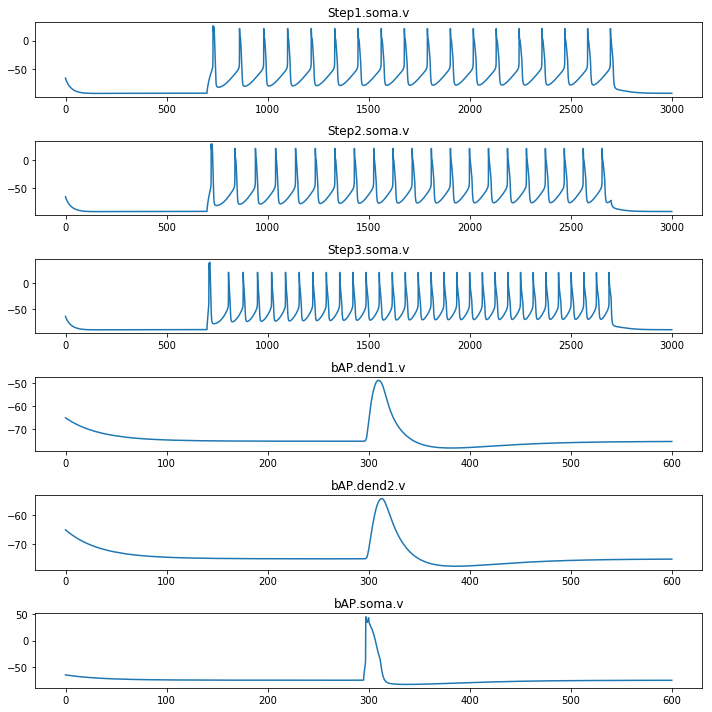

In [58]:
plot_responses(best_responses)

Let's visualize the objectives of the optimisation. First we need to create a dictionary of the responses of the best individual, that is the NEURON simulation of the voltage trace for each protocol with the parameters that correspond to the best individual. Remember that an individual is just a set of our model's parameters.

In [59]:
fitness_protocols = evaluator.fitness_protocols

responses = {}
nrn = ephys.simulators.NrnSimulator()
for protocol in fitness_protocols.values():
    response = protocol.run(
                            cell_model=evaluator.cell_model,
                            param_values=best_params,
                            sim=nrn
                            )
    responses.update(response)

responses

DEBUG:bluepyopt.ephys.morphologies:Loading morphology model/morphology/vd110611_idA.asc
DEBUG:bluepyopt.ephys.morphologies:Replace axon with AIS
DEBUG:bluepyopt.ephys.mechanisms:Inserted pas in ['all']
DEBUG:bluepyopt.ephys.mechanisms:Inserted NaTs2_t in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SKv3_1 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SK_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted CaDynamics_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_HVA in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_LVAst in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ih in ['somatic']
DEBUG:bluepyopt.ephys.parameters:Set g_pas in all to 3e-05
DEBUG:bluepyopt.ephys.parameters:Set e_pas in all to -75
DEBUG:bluepyopt.ephys.parameters:Set cm in all to 1
DEBUG:bluepyopt.ephys.parameters:Set Ra in all to 100
DEBUG:bluepyopt.ephys.parameters:Set v_init to -65
DEBUG:bluepyopt.ephys.parameters:Set celsius to 34
DEBUG:bluepyopt.ephys

DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_LVAst in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ih in ['somatic']
DEBUG:bluepyopt.ephys.parameters:Set g_pas in all to 3e-05
DEBUG:bluepyopt.ephys.parameters:Set e_pas in all to -75
DEBUG:bluepyopt.ephys.parameters:Set cm in all to 1
DEBUG:bluepyopt.ephys.parameters:Set Ra in all to 100
DEBUG:bluepyopt.ephys.parameters:Set v_init to -65
DEBUG:bluepyopt.ephys.parameters:Set celsius to 34
DEBUG:bluepyopt.ephys.parameters:Set ena in somatic to 50
DEBUG:bluepyopt.ephys.parameters:Set ek in somatic to -85
DEBUG:bluepyopt.ephys.parameters:Set gNaTs2_tbar_NaTs2_t in ['somatic'] to 0.60988711158 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSKv3_1bar_SKv3_1 in ['somatic'] to 0.000230220153987 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSK_E2bar_SK_E2 in ['somatic'] to 0.0160360683624 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_HVAbar_Ca_HVA in ['somatic'] to 0.00

{u'Step1.soma.v': <bluepyopt.ephys.responses.TimeVoltageResponse at 0x7f1ce77f7390>,
 u'Step2.soma.v': <bluepyopt.ephys.responses.TimeVoltageResponse at 0x7f1ce76ba9d0>,
 u'Step3.soma.v': <bluepyopt.ephys.responses.TimeVoltageResponse at 0x7f1ce7808dd0>,
 u'bAP.dend1.v': <bluepyopt.ephys.responses.TimeVoltageResponse at 0x7f1ce7808190>,
 u'bAP.dend2.v': <bluepyopt.ephys.responses.TimeVoltageResponse at 0x7f1ce76ba310>,
 u'bAP.soma.v': <bluepyopt.ephys.responses.TimeVoltageResponse at 0x7f1ce76ba7d0>}

Plot the objectives of the responses, that is the deviation (in standard deviations) of the features from the values in the input features.json file.

DEBUG:bluepyopt.ephys.efeatures:Calculated score for Step1.soma.AP_height: 1.337886
DEBUG:bluepyopt.ephys.efeatures:Calculated score for Step1.soma.AHP_slow_time: 1.701415
DEBUG:bluepyopt.ephys.efeatures:Calculated score for Step1.soma.ISI_CV: 0.747989
DEBUG:bluepyopt.ephys.efeatures:Calculated score for Step1.soma.doublet_ISI: 7.081010
DEBUG:bluepyopt.ephys.efeatures:Calculated score for Step1.soma.AHP_depth_abs_slow: 7.043465
DEBUG:bluepyopt.ephys.efeatures:Calculated score for Step1.soma.AP_width: 7.019663
DEBUG:bluepyopt.ephys.efeatures:Calculated score for Step1.soma.time_to_first_spike: 0.480584
DEBUG:bluepyopt.ephys.efeatures:Calculated score for Step1.soma.AHP_depth_abs: 9.019921
DEBUG:bluepyopt.ephys.efeatures:Calculated score for Step1.soma.adaptation_index2: 0.129368
DEBUG:bluepyopt.ephys.efeatures:Calculated score for Step1.soma.mean_frequency: 2.467130
DEBUG:bluepyopt.ephys.efeatures:Calculated score for Step3.soma.AP_height: 0.686547
DEBUG:bluepyopt.ephys.efeatures:Calcul

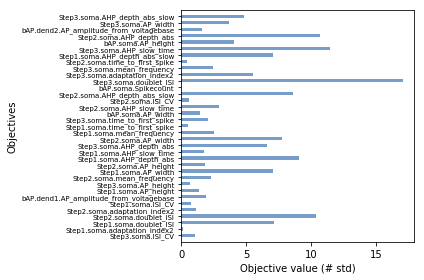

In [60]:
objectives = evaluator.fitness_calculator.calculate_scores(responses)

f, ax = plt.subplots()

ytick_pos = [x + 0.5 for x in range(len(objectives.keys()))]
ax.barh(ytick_pos,
              objectives.values(),
              height=0.5,
              align='center',
              color='#779ECB')

ax.set_yticks(ytick_pos) 
ax.set_yticklabels(objectives.keys(), size='x-small') 
ax.set_ylim(-0.5, len(objectives.values()) + 0.5) 
ax.set_xlabel('Objective value (# std)') 
ax.set_ylabel('Objectives') 

plt.tight_layout()

Let's now plot the traces for all the individuals in the hall of fame. In other words, for each parameter set = individual let's plot the respective trace.

First we create a list for all the individuals, in a simimilar manner as above, but for all the individuals in the hall of fame this time.

In [61]:
hof_responses = []
for best_ind in halloffame:
    best_ind_dict = evaluator.param_dict(best_ind)
    hof_responses.append(evaluator.run_protocols(evaluator.fitness_protocols.values(),
                                             param_values=best_ind_dict))

DEBUG:bluepyopt.ephys.morphologies:Loading morphology model/morphology/vd110611_idA.asc
DEBUG:bluepyopt.ephys.morphologies:Replace axon with AIS
DEBUG:bluepyopt.ephys.mechanisms:Inserted pas in ['all']
DEBUG:bluepyopt.ephys.mechanisms:Inserted NaTs2_t in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SKv3_1 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SK_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted CaDynamics_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_HVA in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_LVAst in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ih in ['somatic']
DEBUG:bluepyopt.ephys.parameters:Set g_pas in all to 3e-05
DEBUG:bluepyopt.ephys.parameters:Set e_pas in all to -75
DEBUG:bluepyopt.ephys.parameters:Set cm in all to 1
DEBUG:bluepyopt.ephys.parameters:Set Ra in all to 100
DEBUG:bluepyopt.ephys.parameters:Set v_init to -65
DEBUG:bluepyopt.ephys.parameters:Set celsius to 34
DEBUG:bluepyopt.ephys

DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_LVAst in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ih in ['somatic']
DEBUG:bluepyopt.ephys.parameters:Set g_pas in all to 3e-05
DEBUG:bluepyopt.ephys.parameters:Set e_pas in all to -75
DEBUG:bluepyopt.ephys.parameters:Set cm in all to 1
DEBUG:bluepyopt.ephys.parameters:Set Ra in all to 100
DEBUG:bluepyopt.ephys.parameters:Set v_init to -65
DEBUG:bluepyopt.ephys.parameters:Set celsius to 34
DEBUG:bluepyopt.ephys.parameters:Set ena in somatic to 50
DEBUG:bluepyopt.ephys.parameters:Set ek in somatic to -85
DEBUG:bluepyopt.ephys.parameters:Set gNaTs2_tbar_NaTs2_t in ['somatic'] to 0.60988711158 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSKv3_1bar_SKv3_1 in ['somatic'] to 0.000230220153987 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSK_E2bar_SK_E2 in ['somatic'] to 0.0160360683624 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_HVAbar_Ca_HVA in ['somatic'] to 0.00

DEBUG:bluepyopt.ephys.parameters:Set ek in somatic to -85
DEBUG:bluepyopt.ephys.parameters:Set gNaTs2_tbar_NaTs2_t in ['somatic'] to 0.62027473583 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSKv3_1bar_SKv3_1 in ['somatic'] to 0.000223441681522 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSK_E2bar_SK_E2 in ['somatic'] to 0.0142650770534 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_HVAbar_Ca_HVA in ['somatic'] to 0.000368549667559 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_LVAstbar_Ca_LVAst in ['somatic'] to 0.000874916336409 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gamma_CaDynamics_E2 in ['somatic'] to 0.00100648975558 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set decay_CaDynamics_E2 in ['somatic'] to 120.166607343 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gIhbar_Ih in ['somatic'] to 8e-05 with scaler 1.0 * value + 0

DEBUG:bluepyopt.ephys.parameters:Set gCa_LVAstbar_Ca_LVAst in ['somatic'] to 0.00287104998017 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gamma_CaDynamics_E2 in ['somatic'] to 0.000577268578842 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set decay_CaDynamics_E2 in ['somatic'] to 72.4076749015 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gIhbar_Ih in ['somatic'] to 8e-05 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.stimuli:Adding square step stimulus to somatic[0](0.5) with delay 700.000000, duration 2000.000000, and amplitude 0.950000
DEBUG:bluepyopt.ephys.stimuli:Adding square step stimulus to somatic[0](0.5) with delay 0.000000, duration 3000.000000, and amplitude -0.126000
DEBUG:bluepyopt.ephys.recordings:Adding compartment recording of v at somatic[0](0.5)
DEBUG:bluepyopt.ephys.simulators:Running Neuron simulator 3000 ms, with cvode
DEBUG:bluepyopt.ephys.simulators:Neuron simulation finished
DEBUG:bluepyopt.ephy

DEBUG:bluepyopt.ephys.recordings:Adding compartment recording of v at somatic[0](0.5)
DEBUG:bluepyopt.ephys.recordings:Adding compartment recording of v at 660.000000 micron from soma in apical
DEBUG:bluepyopt.ephys.recordings:Adding compartment recording of v at 800.000000 micron from soma in apical
DEBUG:bluepyopt.ephys.simulators:Running Neuron simulator 600 ms, with cvode
DEBUG:bluepyopt.ephys.simulators:Neuron simulation finished
DEBUG:bluepyopt.ephys.morphologies:Loading morphology model/morphology/vd110611_idA.asc
DEBUG:bluepyopt.ephys.morphologies:Replace axon with AIS
DEBUG:bluepyopt.ephys.mechanisms:Inserted pas in ['all']
DEBUG:bluepyopt.ephys.mechanisms:Inserted NaTs2_t in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SKv3_1 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SK_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted CaDynamics_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_HVA in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms

DEBUG:bluepyopt.ephys.mechanisms:Inserted pas in ['all']
DEBUG:bluepyopt.ephys.mechanisms:Inserted NaTs2_t in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SKv3_1 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SK_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted CaDynamics_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_HVA in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_LVAst in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ih in ['somatic']
DEBUG:bluepyopt.ephys.parameters:Set g_pas in all to 3e-05
DEBUG:bluepyopt.ephys.parameters:Set e_pas in all to -75
DEBUG:bluepyopt.ephys.parameters:Set cm in all to 1
DEBUG:bluepyopt.ephys.parameters:Set Ra in all to 100
DEBUG:bluepyopt.ephys.parameters:Set v_init to -65
DEBUG:bluepyopt.ephys.parameters:Set celsius to 34
DEBUG:bluepyopt.ephys.parameters:Set ena in somatic to 50
DEBUG:bluepyopt.ephys.parameters:Set ek in somatic to -85
DEBUG:bluepyopt.ephys.parameters:Set gNaTs2_tbar_N

DEBUG:bluepyopt.ephys.parameters:Set g_pas in all to 3e-05
DEBUG:bluepyopt.ephys.parameters:Set e_pas in all to -75
DEBUG:bluepyopt.ephys.parameters:Set cm in all to 1
DEBUG:bluepyopt.ephys.parameters:Set Ra in all to 100
DEBUG:bluepyopt.ephys.parameters:Set v_init to -65
DEBUG:bluepyopt.ephys.parameters:Set celsius to 34
DEBUG:bluepyopt.ephys.parameters:Set ena in somatic to 50
DEBUG:bluepyopt.ephys.parameters:Set ek in somatic to -85
DEBUG:bluepyopt.ephys.parameters:Set gNaTs2_tbar_NaTs2_t in ['somatic'] to 0.566410776467 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSKv3_1bar_SKv3_1 in ['somatic'] to 0.000740023997759 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSK_E2bar_SK_E2 in ['somatic'] to 0.0117766633011 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_HVAbar_Ca_HVA in ['somatic'] to 0.000240240072219 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_LVAstbar_Ca_LVAst in ['somatic'] to 3.33

DEBUG:bluepyopt.ephys.parameters:Set gSKv3_1bar_SKv3_1 in ['somatic'] to 0.000724078077897 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSK_E2bar_SK_E2 in ['somatic'] to 0.0208645013752 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_HVAbar_Ca_HVA in ['somatic'] to 0.000178769930012 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_LVAstbar_Ca_LVAst in ['somatic'] to 5.1956620406e-05 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gamma_CaDynamics_E2 in ['somatic'] to 0.00100648975558 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set decay_CaDynamics_E2 in ['somatic'] to 105.980498567 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gIhbar_Ih in ['somatic'] to 8e-05 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.stimuli:Adding square step stimulus to somatic[0](0.5) with delay 700.000000, duration 2000.000000, and amplitude 0.562000
DEBUG:bluepyopt.ephys.stimuli:

DEBUG:bluepyopt.ephys.parameters:Set gamma_CaDynamics_E2 in ['somatic'] to 0.000776097021722 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set decay_CaDynamics_E2 in ['somatic'] to 51.8580515183 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gIhbar_Ih in ['somatic'] to 8e-05 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.stimuli:Adding square step stimulus to somatic[0](0.5) with delay 700.000000, duration 2000.000000, and amplitude 0.950000
DEBUG:bluepyopt.ephys.stimuli:Adding square step stimulus to somatic[0](0.5) with delay 0.000000, duration 3000.000000, and amplitude -0.126000
DEBUG:bluepyopt.ephys.recordings:Adding compartment recording of v at somatic[0](0.5)
DEBUG:bluepyopt.ephys.simulators:Running Neuron simulator 3000 ms, with cvode
DEBUG:bluepyopt.ephys.simulators:Neuron simulation finished
DEBUG:bluepyopt.ephys.morphologies:Loading morphology model/morphology/vd110611_idA.asc
DEBUG:bluepyopt.ephys.morphologies:Replace axon with AIS

DEBUG:bluepyopt.ephys.recordings:Adding compartment recording of v at 660.000000 micron from soma in apical
DEBUG:bluepyopt.ephys.recordings:Adding compartment recording of v at 800.000000 micron from soma in apical
DEBUG:bluepyopt.ephys.simulators:Running Neuron simulator 600 ms, with cvode
DEBUG:bluepyopt.ephys.simulators:Neuron simulation finished
DEBUG:bluepyopt.ephys.morphologies:Loading morphology model/morphology/vd110611_idA.asc
DEBUG:bluepyopt.ephys.morphologies:Replace axon with AIS
DEBUG:bluepyopt.ephys.mechanisms:Inserted pas in ['all']
DEBUG:bluepyopt.ephys.mechanisms:Inserted NaTs2_t in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SKv3_1 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SK_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted CaDynamics_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_HVA in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_LVAst in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ih in ['so

DEBUG:bluepyopt.ephys.mechanisms:Inserted NaTs2_t in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SKv3_1 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SK_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted CaDynamics_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_HVA in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_LVAst in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ih in ['somatic']
DEBUG:bluepyopt.ephys.parameters:Set g_pas in all to 3e-05
DEBUG:bluepyopt.ephys.parameters:Set e_pas in all to -75
DEBUG:bluepyopt.ephys.parameters:Set cm in all to 1
DEBUG:bluepyopt.ephys.parameters:Set Ra in all to 100
DEBUG:bluepyopt.ephys.parameters:Set v_init to -65
DEBUG:bluepyopt.ephys.parameters:Set celsius to 34
DEBUG:bluepyopt.ephys.parameters:Set ena in somatic to 50
DEBUG:bluepyopt.ephys.parameters:Set ek in somatic to -85
DEBUG:bluepyopt.ephys.parameters:Set gNaTs2_tbar_NaTs2_t in ['somatic'] to 0.537431464997 with scaler 1.0 *

DEBUG:bluepyopt.ephys.parameters:Set e_pas in all to -75
DEBUG:bluepyopt.ephys.parameters:Set cm in all to 1
DEBUG:bluepyopt.ephys.parameters:Set Ra in all to 100
DEBUG:bluepyopt.ephys.parameters:Set v_init to -65
DEBUG:bluepyopt.ephys.parameters:Set celsius to 34
DEBUG:bluepyopt.ephys.parameters:Set ena in somatic to 50
DEBUG:bluepyopt.ephys.parameters:Set ek in somatic to -85
DEBUG:bluepyopt.ephys.parameters:Set gNaTs2_tbar_NaTs2_t in ['somatic'] to 0.537431464997 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSKv3_1bar_SKv3_1 in ['somatic'] to 0.000140825237955 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSK_E2bar_SK_E2 in ['somatic'] to 0.0117852771504 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_HVAbar_Ca_HVA in ['somatic'] to 0.000690665089046 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_LVAstbar_Ca_LVAst in ['somatic'] to 3.34133947223e-05 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt

DEBUG:bluepyopt.ephys.parameters:Set gSKv3_1bar_SKv3_1 in ['somatic'] to 1.17533814989e-05 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSK_E2bar_SK_E2 in ['somatic'] to 0.0162287329302 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_HVAbar_Ca_HVA in ['somatic'] to 0.000531882642531 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_LVAstbar_Ca_LVAst in ['somatic'] to 0.00051216376101 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gamma_CaDynamics_E2 in ['somatic'] to 0.000610496467019 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set decay_CaDynamics_E2 in ['somatic'] to 49.9891086853 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gIhbar_Ih in ['somatic'] to 8e-05 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.stimuli:Adding square step stimulus to somatic[0](0.5) with delay 700.000000, duration 2000.000000, and amplitude 0.562000
DEBUG:bluepyopt.ephys.stimuli

Let's now plot the traces for all the individuals in the hall of fame. In other words, for each parameter set = individual let's plot the respective trace.

First we create a list for all the individuals, in a simimilar manner as above, but for all the individuals in the hall of fame this time.


In [62]:
hof_responses = []
for best_ind in halloffame:
    best_ind_dict = evaluator.param_dict(best_ind)
    hof_responses.append(evaluator.run_protocols(evaluator.fitness_protocols.values(),
                                             param_values=best_ind_dict))

DEBUG:bluepyopt.ephys.morphologies:Loading morphology model/morphology/vd110611_idA.asc
DEBUG:bluepyopt.ephys.morphologies:Replace axon with AIS
DEBUG:bluepyopt.ephys.mechanisms:Inserted pas in ['all']
DEBUG:bluepyopt.ephys.mechanisms:Inserted NaTs2_t in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SKv3_1 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SK_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted CaDynamics_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_HVA in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_LVAst in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ih in ['somatic']
DEBUG:bluepyopt.ephys.parameters:Set g_pas in all to 3e-05
DEBUG:bluepyopt.ephys.parameters:Set e_pas in all to -75
DEBUG:bluepyopt.ephys.parameters:Set cm in all to 1
DEBUG:bluepyopt.ephys.parameters:Set Ra in all to 100
DEBUG:bluepyopt.ephys.parameters:Set v_init to -65
DEBUG:bluepyopt.ephys.parameters:Set celsius to 34
DEBUG:bluepyopt.ephys

DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_LVAst in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ih in ['somatic']
DEBUG:bluepyopt.ephys.parameters:Set g_pas in all to 3e-05
DEBUG:bluepyopt.ephys.parameters:Set e_pas in all to -75
DEBUG:bluepyopt.ephys.parameters:Set cm in all to 1
DEBUG:bluepyopt.ephys.parameters:Set Ra in all to 100
DEBUG:bluepyopt.ephys.parameters:Set v_init to -65
DEBUG:bluepyopt.ephys.parameters:Set celsius to 34
DEBUG:bluepyopt.ephys.parameters:Set ena in somatic to 50
DEBUG:bluepyopt.ephys.parameters:Set ek in somatic to -85
DEBUG:bluepyopt.ephys.parameters:Set gNaTs2_tbar_NaTs2_t in ['somatic'] to 0.60988711158 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSKv3_1bar_SKv3_1 in ['somatic'] to 0.000230220153987 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSK_E2bar_SK_E2 in ['somatic'] to 0.0160360683624 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_HVAbar_Ca_HVA in ['somatic'] to 0.00

DEBUG:bluepyopt.ephys.parameters:Set ek in somatic to -85
DEBUG:bluepyopt.ephys.parameters:Set gNaTs2_tbar_NaTs2_t in ['somatic'] to 0.62027473583 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSKv3_1bar_SKv3_1 in ['somatic'] to 0.000223441681522 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSK_E2bar_SK_E2 in ['somatic'] to 0.0142650770534 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_HVAbar_Ca_HVA in ['somatic'] to 0.000368549667559 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_LVAstbar_Ca_LVAst in ['somatic'] to 0.000874916336409 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gamma_CaDynamics_E2 in ['somatic'] to 0.00100648975558 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set decay_CaDynamics_E2 in ['somatic'] to 120.166607343 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gIhbar_Ih in ['somatic'] to 8e-05 with scaler 1.0 * value + 0

DEBUG:bluepyopt.ephys.parameters:Set gCa_LVAstbar_Ca_LVAst in ['somatic'] to 0.00287104998017 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gamma_CaDynamics_E2 in ['somatic'] to 0.000577268578842 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set decay_CaDynamics_E2 in ['somatic'] to 72.4076749015 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gIhbar_Ih in ['somatic'] to 8e-05 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.stimuli:Adding square step stimulus to somatic[0](0.5) with delay 700.000000, duration 2000.000000, and amplitude 0.950000
DEBUG:bluepyopt.ephys.stimuli:Adding square step stimulus to somatic[0](0.5) with delay 0.000000, duration 3000.000000, and amplitude -0.126000
DEBUG:bluepyopt.ephys.recordings:Adding compartment recording of v at somatic[0](0.5)
DEBUG:bluepyopt.ephys.simulators:Running Neuron simulator 3000 ms, with cvode
DEBUG:bluepyopt.ephys.simulators:Neuron simulation finished
DEBUG:bluepyopt.ephy

DEBUG:bluepyopt.ephys.recordings:Adding compartment recording of v at somatic[0](0.5)
DEBUG:bluepyopt.ephys.recordings:Adding compartment recording of v at 660.000000 micron from soma in apical
DEBUG:bluepyopt.ephys.recordings:Adding compartment recording of v at 800.000000 micron from soma in apical
DEBUG:bluepyopt.ephys.simulators:Running Neuron simulator 600 ms, with cvode
DEBUG:bluepyopt.ephys.simulators:Neuron simulation finished
DEBUG:bluepyopt.ephys.morphologies:Loading morphology model/morphology/vd110611_idA.asc
DEBUG:bluepyopt.ephys.morphologies:Replace axon with AIS
DEBUG:bluepyopt.ephys.mechanisms:Inserted pas in ['all']
DEBUG:bluepyopt.ephys.mechanisms:Inserted NaTs2_t in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SKv3_1 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SK_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted CaDynamics_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_HVA in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms

DEBUG:bluepyopt.ephys.mechanisms:Inserted pas in ['all']
DEBUG:bluepyopt.ephys.mechanisms:Inserted NaTs2_t in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SKv3_1 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SK_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted CaDynamics_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_HVA in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_LVAst in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ih in ['somatic']
DEBUG:bluepyopt.ephys.parameters:Set g_pas in all to 3e-05
DEBUG:bluepyopt.ephys.parameters:Set e_pas in all to -75
DEBUG:bluepyopt.ephys.parameters:Set cm in all to 1
DEBUG:bluepyopt.ephys.parameters:Set Ra in all to 100
DEBUG:bluepyopt.ephys.parameters:Set v_init to -65
DEBUG:bluepyopt.ephys.parameters:Set celsius to 34
DEBUG:bluepyopt.ephys.parameters:Set ena in somatic to 50
DEBUG:bluepyopt.ephys.parameters:Set ek in somatic to -85
DEBUG:bluepyopt.ephys.parameters:Set gNaTs2_tbar_N

DEBUG:bluepyopt.ephys.parameters:Set g_pas in all to 3e-05
DEBUG:bluepyopt.ephys.parameters:Set e_pas in all to -75
DEBUG:bluepyopt.ephys.parameters:Set cm in all to 1
DEBUG:bluepyopt.ephys.parameters:Set Ra in all to 100
DEBUG:bluepyopt.ephys.parameters:Set v_init to -65
DEBUG:bluepyopt.ephys.parameters:Set celsius to 34
DEBUG:bluepyopt.ephys.parameters:Set ena in somatic to 50
DEBUG:bluepyopt.ephys.parameters:Set ek in somatic to -85
DEBUG:bluepyopt.ephys.parameters:Set gNaTs2_tbar_NaTs2_t in ['somatic'] to 0.566410776467 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSKv3_1bar_SKv3_1 in ['somatic'] to 0.000740023997759 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSK_E2bar_SK_E2 in ['somatic'] to 0.0117766633011 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_HVAbar_Ca_HVA in ['somatic'] to 0.000240240072219 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_LVAstbar_Ca_LVAst in ['somatic'] to 3.33

DEBUG:bluepyopt.ephys.parameters:Set gSKv3_1bar_SKv3_1 in ['somatic'] to 0.000724078077897 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSK_E2bar_SK_E2 in ['somatic'] to 0.0208645013752 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_HVAbar_Ca_HVA in ['somatic'] to 0.000178769930012 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_LVAstbar_Ca_LVAst in ['somatic'] to 5.1956620406e-05 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gamma_CaDynamics_E2 in ['somatic'] to 0.00100648975558 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set decay_CaDynamics_E2 in ['somatic'] to 105.980498567 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gIhbar_Ih in ['somatic'] to 8e-05 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.stimuli:Adding square step stimulus to somatic[0](0.5) with delay 700.000000, duration 2000.000000, and amplitude 0.562000
DEBUG:bluepyopt.ephys.stimuli:

DEBUG:bluepyopt.ephys.parameters:Set gamma_CaDynamics_E2 in ['somatic'] to 0.000776097021722 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set decay_CaDynamics_E2 in ['somatic'] to 51.8580515183 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gIhbar_Ih in ['somatic'] to 8e-05 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.stimuli:Adding square step stimulus to somatic[0](0.5) with delay 700.000000, duration 2000.000000, and amplitude 0.950000
DEBUG:bluepyopt.ephys.stimuli:Adding square step stimulus to somatic[0](0.5) with delay 0.000000, duration 3000.000000, and amplitude -0.126000
DEBUG:bluepyopt.ephys.recordings:Adding compartment recording of v at somatic[0](0.5)
DEBUG:bluepyopt.ephys.simulators:Running Neuron simulator 3000 ms, with cvode
DEBUG:bluepyopt.ephys.simulators:Neuron simulation finished
DEBUG:bluepyopt.ephys.morphologies:Loading morphology model/morphology/vd110611_idA.asc
DEBUG:bluepyopt.ephys.morphologies:Replace axon with AIS

DEBUG:bluepyopt.ephys.recordings:Adding compartment recording of v at 660.000000 micron from soma in apical
DEBUG:bluepyopt.ephys.recordings:Adding compartment recording of v at 800.000000 micron from soma in apical
DEBUG:bluepyopt.ephys.simulators:Running Neuron simulator 600 ms, with cvode
DEBUG:bluepyopt.ephys.simulators:Neuron simulation finished
DEBUG:bluepyopt.ephys.morphologies:Loading morphology model/morphology/vd110611_idA.asc
DEBUG:bluepyopt.ephys.morphologies:Replace axon with AIS
DEBUG:bluepyopt.ephys.mechanisms:Inserted pas in ['all']
DEBUG:bluepyopt.ephys.mechanisms:Inserted NaTs2_t in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SKv3_1 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SK_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted CaDynamics_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_HVA in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_LVAst in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ih in ['so

DEBUG:bluepyopt.ephys.mechanisms:Inserted NaTs2_t in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SKv3_1 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted SK_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted CaDynamics_E2 in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_HVA in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ca_LVAst in ['somatic']
DEBUG:bluepyopt.ephys.mechanisms:Inserted Ih in ['somatic']
DEBUG:bluepyopt.ephys.parameters:Set g_pas in all to 3e-05
DEBUG:bluepyopt.ephys.parameters:Set e_pas in all to -75
DEBUG:bluepyopt.ephys.parameters:Set cm in all to 1
DEBUG:bluepyopt.ephys.parameters:Set Ra in all to 100
DEBUG:bluepyopt.ephys.parameters:Set v_init to -65
DEBUG:bluepyopt.ephys.parameters:Set celsius to 34
DEBUG:bluepyopt.ephys.parameters:Set ena in somatic to 50
DEBUG:bluepyopt.ephys.parameters:Set ek in somatic to -85
DEBUG:bluepyopt.ephys.parameters:Set gNaTs2_tbar_NaTs2_t in ['somatic'] to 0.537431464997 with scaler 1.0 *

DEBUG:bluepyopt.ephys.parameters:Set e_pas in all to -75
DEBUG:bluepyopt.ephys.parameters:Set cm in all to 1
DEBUG:bluepyopt.ephys.parameters:Set Ra in all to 100
DEBUG:bluepyopt.ephys.parameters:Set v_init to -65
DEBUG:bluepyopt.ephys.parameters:Set celsius to 34
DEBUG:bluepyopt.ephys.parameters:Set ena in somatic to 50
DEBUG:bluepyopt.ephys.parameters:Set ek in somatic to -85
DEBUG:bluepyopt.ephys.parameters:Set gNaTs2_tbar_NaTs2_t in ['somatic'] to 0.537431464997 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSKv3_1bar_SKv3_1 in ['somatic'] to 0.000140825237955 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSK_E2bar_SK_E2 in ['somatic'] to 0.0117852771504 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_HVAbar_Ca_HVA in ['somatic'] to 0.000690665089046 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_LVAstbar_Ca_LVAst in ['somatic'] to 3.34133947223e-05 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt

DEBUG:bluepyopt.ephys.parameters:Set gSKv3_1bar_SKv3_1 in ['somatic'] to 1.17533814989e-05 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gSK_E2bar_SK_E2 in ['somatic'] to 0.0162287329302 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_HVAbar_Ca_HVA in ['somatic'] to 0.000531882642531 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gCa_LVAstbar_Ca_LVAst in ['somatic'] to 0.00051216376101 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gamma_CaDynamics_E2 in ['somatic'] to 0.000610496467019 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set decay_CaDynamics_E2 in ['somatic'] to 49.9891086853 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.parameters:Set gIhbar_Ih in ['somatic'] to 8e-05 with scaler 1.0 * value + 0.0
DEBUG:bluepyopt.ephys.stimuli:Adding square step stimulus to somatic[0](0.5) with delay 700.000000, duration 2000.000000, and amplitude 0.562000
DEBUG:bluepyopt.ephys.stimuli

In [63]:
traces = sorted(hof_responses[0].keys())

traces

[u'Step1.soma.v',
 u'Step2.soma.v',
 u'Step3.soma.v',
 u'bAP.dend1.v',
 u'bAP.dend2.v',
 u'bAP.soma.v']

Then we plot the traces with the best one in deep blue

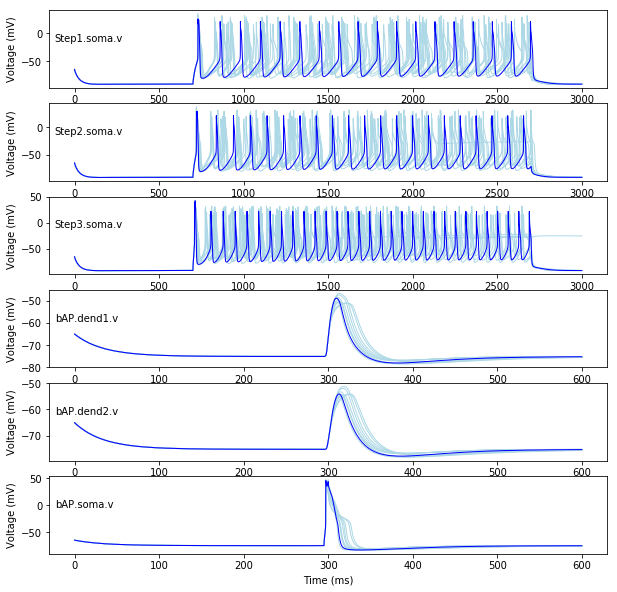

In [64]:
import numpy as np

def plot_multiple_responses(responses, fig):
    '''creates 6 subplots for step{1,2,3} and dAP traces, and plots all the responses on them'''

    plot_count = len(traces)
    
    # one subplot for each trace
    ax = [fig.add_subplot(plot_count, 1, i + 1) for i in range(plot_count)]

    # to color the last one deep blue
    overlay_count = len(responses)
    
    for index, trace in enumerate(traces):  
        for n, response in enumerate(reversed(responses)): # worst to best individual
            
            color='lightblue' if n < overlay_count - 1 else 'blue'
            
            ax[index].plot(response[trace]['time'],
                           response[trace]['voltage'],
                           color=color,
                           linewidth=1)

        # formatting of the subplots
        ax[index].set_xlabel('Time (ms)')
        ax[index].set_ylabel('Voltage (mV)')
        ax[index].text(0.01, 0.7, trace, transform=ax[index].transAxes, fontsize=10,
        verticalalignment='top')
        #ax[index].set_xlim(80, 200)
            

        
f = plt.figure(figsize=(10,10))
plot_multiple_responses(hof_responses, f)

In [65]:
responses

{u'Step1.soma.v': <bluepyopt.ephys.responses.TimeVoltageResponse at 0x7f1ce77f7390>,
 u'Step2.soma.v': <bluepyopt.ephys.responses.TimeVoltageResponse at 0x7f1ce76ba9d0>,
 u'Step3.soma.v': <bluepyopt.ephys.responses.TimeVoltageResponse at 0x7f1ce7808dd0>,
 u'bAP.dend1.v': <bluepyopt.ephys.responses.TimeVoltageResponse at 0x7f1ce7808190>,
 u'bAP.dend2.v': <bluepyopt.ephys.responses.TimeVoltageResponse at 0x7f1ce76ba310>,
 u'bAP.soma.v': <bluepyopt.ephys.responses.TimeVoltageResponse at 0x7f1ce76ba7d0>}

And finally the fitness function

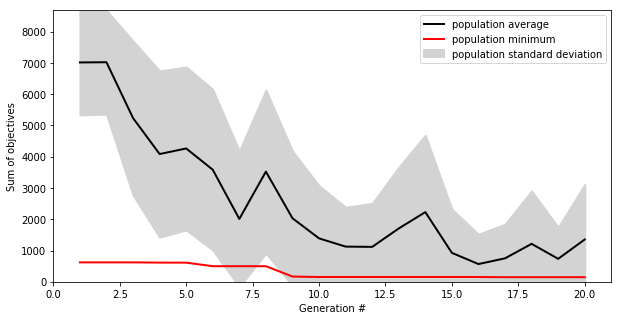

In [66]:
import numpy

logs=log
gen_numbers = log.select('gen')
min_fitness = numpy.array(log.select('min'))
max_fitness = log.select('max')
mean_fitness = numpy.array(log.select('avg'))
std_fitness = numpy.array(log.select('std'))

fig, ax = plt.subplots(1, figsize=(10, 5), facecolor='white')

std = std_fitness
mean = mean_fitness
minimum = min_fitness
stdminus = mean - std                                                           
stdplus = mean + std

ax.plot(                                                                      
    gen_numbers,                                                                
    mean,                                                                       
    color='black',                                                              
    linewidth=2,                                                                
    label='population average')                                                 

ax.fill_between(                                                              
    gen_numbers,                                                                
    stdminus,                                                                   
    stdplus,                                                                    
    color='lightgray',                                                          
    linewidth=2,                                                                
    label=r'population standard deviation')                                     

ax.plot(                                                                      
    gen_numbers,                                                                
    minimum,                                                                    
    color='red',                                                                
    linewidth=2,                                                                
    label='population minimum')                                                 

ax.set_xlim(min(gen_numbers) - 1, max(gen_numbers) + 1)                       
ax.set_xlabel('Generation #')                                                 
ax.set_ylabel('Sum of objectives')                                            
ax.set_ylim([0, max(stdplus)])                                                
ax.legend()                        


fig.show()
